## Описание проекта

Соревнование по предсказанию пользовательской оценки отелю.

Для оценки используется `MAPE` — средняя абсолютная ошибка в процентах. То есть на какой средний процент прогноз модели отклоняется от фактического значения. Чем **меньше** значение, тем **лучше** работает модель.
$$
\text{MAPE} = 100 \cdot \frac{1}{n} \sum_{t=1}^{n} \left| \frac{A_t - F_t}{A_t} \right|
$$

### Описание данных
- **`Hotel_Address`** - Адрес отеля.
- **`Review_Date`** - Дата публикации отзыва.
- **`Average_Score`** - Средняя оценка отеля, рассчитанная на основе комментариев за последний год.
- **`Hotel_Name`** - Название отеля.
- **`Reviewer_Nationality`** - Национальность рецензента.
- **`Negative_Review`** - Отрицательный отзыв, оставленный рецензентом отелю. В случае отсутствия заполняется значением `'No Negative'`.
- **`Review_Total_Negative_Word_Counts`** - Количество слов в отрицательном отзыве.
- **`Positive_Review`** - Положительный отзыв, оставленный рецензентом отелю. В случае отсутствия заполняется значением `'No Positive'`.
- **`Review_Total_Positive_Word_Counts`** - Количество слов в положительном отзыве.
- **`Total_Number_of_Reviews_Reviewer_Has_Given`** - Количество отзывов, написанных рецензентом в прошлом.
- **`Total_Number_of_Reviews`** - Количество отзывов об отеле.
- **`Tags`** - Теги, данные рецензентом отелю.
- **`days_since_review`** - Количество дней между написанием отзыва и чисткой.
- **`Additional_number_of_soring`** - Средний балл отеля, на основе всех оценок — с текстом отзыва и без.
- **`lat`** - Широта отеля.
- **`lng`** - Долгота отеля.
- **`Reviewer_Score`** - Оценка, данная рецензентом отелю. **Целевая переменная**.




In [132]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import ast
from collections import defaultdict

import phik
# import shap

from sklearn.metrics import mean_absolute_percentage_error, make_scorer

# Импорт для разбивки и кодирования данных
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    # Разбиение данных
    train_test_split,

    # Поиск гиперпараметров
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    # Кодирование числовых значений
    StandardScaler,
    MinMaxScaler,
    RobustScaler,

    # Кодирование категориальных значение
    OneHotEncoder,
    LabelEncoder
)

# Импорт для создания пайплайна
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso
)

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

RANDOM_STATE = 42

## Загрузка и предобработка данных

Загрузим тренировочную и тестовую выборки, после чего приведем их к единому стилю.

In [3]:
# Загружаем данные
df = pd.read_csv('data/train.csv', parse_dates=['Review_Date'])
test_df = pd.read_csv('data/test.csv', parse_dates=['Review_Date'])

In [4]:
# Выводим данные о тренировочном датасете
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Additional_Number_of_Scoring,412590.0,498.012994,1.0,169.0,341.0,660.0,2682.0,500.543501
Review_Date,412590,2016-08-13 15:26:43.286555648,2015-08-04 00:00:00,2016-02-23 00:00:00,2016-08-15 00:00:00,2017-02-09 00:00:00,2017-08-03 00:00:00,NaN
Review_Total_Negative_Word_Counts,412590.0,18.551618,0.0,2.0,9.0,23.0,408.0,29.663553
Total_Number_of_Reviews,412590.0,2744.936336,43.0,1161.0,2134.0,3633.0,16670.0,2319.361934
Review_Total_Positive_Word_Counts,412590.0,17.793614,0.0,5.0,11.0,22.0,395.0,21.820234
Total_Number_of_Reviews_Reviewer_Has_Given,412590.0,7.166359,1.0,1.0,3.0,8.0,355.0,11.057331
Reviewer_Score,412590.0,8.395058,2.5,7.5,8.8,9.6,10.0,1.63788
lat,409990.0,49.440722,41.328376,48.214277,51.499981,51.516384,52.400181,3.468718
lng,409990.0,2.826807,-0.369758,-0.143372,0.019886,4.834443,16.429233,4.575712


In [5]:
# Выводим данные в тренировочном датасете
df

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,Ndsm Plein 28 Amsterdam Noord 1033 WB Amsterda...,170,2017-04-17,DoubleTree by Hilton Hotel Amsterdam NDSM Wharf,United Kingdom,Too far from attractions Had to use ferry to ...,72,1593,Staff were very helpful Good breakfast,8,1,5.4,"[' Leisure trip ', ' Couple ', ' Queen Guest R...",108 day,52.400181,4.893665
1,Ferdinand Bolstraat 194 Oud Zuid 1072 LW Amste...,114,2016-05-26,Savoy Hotel Amsterdam,Malaysia,Staff should handle customer document during ...,246,995,Very clean and cozy room Friendly and helpful...,41,1,9.6,"[' Leisure trip ', ' Couple ', ' Small Double ...",434 day,52.349743,4.891191
2,18 Albert Embankment Lambeth London SE1 7TJ Un...,1195,2016-12-04,Park Plaza London Riverbank,United Kingdom,The hot breakfast could have been fresher tas...,19,4684,The room was to a high standard The staff wer...,19,3,8.8,"[' Business trip ', ' Solo traveler ', ' Super...",242 day,51.491374,-0.121419
3,Schottenring 24 01 Innere Stadt 1010 Vienna Au...,111,2017-04-30,Palais Hansen Kempinski Vienna,Oman,You have to pay the full amount before arrivi...,14,865,Everything was excellent,5,21,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe Room '...",95 days,48.216315,16.368510
4,Sabino de Arana 22 24 Les Corts 08028 Barcelon...,147,2017-01-22,Catalonia Rigoletto,United Kingdom,All Good,3,1562,The location was excellent for visiting the N...,11,1,9.2,"[' Leisure trip ', ' Family with young childre...",193 day,41.385817,2.125679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412585,7 Gracechurch Street City of London London EC3...,764,2017-03-31,Club Quarters Hotel Gracechurch,Belgium,Most of the coffee shops around the hotel are...,24,2996,Good location at walking distance to metro st...,75,28,9.2,"[' Leisure trip ', ' Couple ', ' Small Queen R...",125 day,51.512796,-0.084797
412586,Westminster Bridge Road Lambeth London SE1 7UT...,2623,2017-05-19,Park Plaza Westminster Bridge London,United Kingdom,Bar rather expensive,4,12158,Location and quality of the go Room was a gre...,17,4,10.0,"[' Leisure trip ', ' Family with young childre...",76 days,51.500961,-0.116591
412587,2 Stanhope Row Park Lane Westminster Borough L...,444,2015-12-07,Park Lane Mews Hotel,United Kingdom,Lack of ironing facilities Asked for iron to ...,21,2061,Excellent location comfortable and clean,6,1,7.9,"[' Business trip ', ' Solo traveler ', ' Doubl...",605 day,51.505933,-0.148942
412588,No 1 Seething Lane City of London London EC3N ...,623,2017-04-16,Apex City Of London Hotel,United Kingdom,Having stayed at this hotel a number of times...,29,2750,All the staff where very friendly helpful Hot...,41,4,8.3,"[' Leisure trip ', ' Couple ', ' City King or ...",109 day,51.510462,-0.079550


In [6]:
# Выделяем год месяц и день
df['review_year'] = df['Review_Date'].dt.year
df['review_month'] = df['Review_Date'].dt.month
df['review_day'] = df['Review_Date'].dt.day

# Преобразуем столбец с днями в числовой
df['days_since_review'] = df['days_since_review'].apply(lambda x: x.split()[0]).astype('int64')
df['days_since_review'].head()

0    108
1    434
2    242
3     95
4    193
Name: days_since_review, dtype: int64

In [7]:
# Выводим данные о тестовом датасете
test_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Additional_Number_of_Scoring,103148.0,498.357205,1.0,169.0,341.5,660.0,2682.0,500.520661
Review_Date,103148,2016-08-13 05:11:12.478380544,2015-08-04 00:00:00,2016-02-22 00:00:00,2016-08-15 00:00:00,2017-02-09 00:00:00,2017-08-03 00:00:00,NaN
Review_Total_Negative_Word_Counts,103148.0,18.49078,0.0,2.0,9.0,23.0,403.0,29.799785
Total_Number_of_Reviews,103148.0,2738.974396,43.0,1164.0,2134.0,3611.0,16670.0,2309.866121
Review_Total_Positive_Word_Counts,103148.0,17.707837,0.0,5.0,11.0,22.0,383.0,21.739841
Total_Number_of_Reviews_Reviewer_Has_Given,103148.0,7.164569,1.0,1.0,3.0,8.0,297.0,10.971602
lat,102480.0,49.44931,41.328376,48.214662,51.500198,51.516288,52.400181,3.456744
lng,102480.0,2.811787,-0.369758,-0.143671,-0.00025,4.820783,16.429233,4.594254


In [8]:
# Выводим данные в тестовом датасете
test_df

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Tags,days_since_review,lat,lng
0,7 Western Gateway Royal Victoria Dock Newham L...,359,2015-08-14,Novotel London Excel,United Kingdom,No Negative,0,1158,Excellent location for Excel centre Friendly ...,14,5,"[' Leisure trip ', ' Family with young childre...",720 day,51.507720,0.022981
1,Great Cumberland Place Westminster Borough Lon...,1190,2017-08-03,The Cumberland A Guoman Hotel,Gibraltar,No Negative,0,5180,The location was excellent rieally good next ...,11,2,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.514879,-0.160650
2,14 Rue de la Sorbonne 5th arr 75005 Paris France,37,2016-04-27,Hotel Mercure La Sorbonne Saint Germain des Pr s,United Kingdom,The beds were uncomfortable We requested a do...,31,464,The buffet breakfast was excellent The breakf...,22,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",463 day,48.849350,2.343057
3,4 Broad Court Bow Street Covent Garden Westmin...,294,2016-03-03,Fielding Hotel,United Kingdom,No negatives,3,1271,Beautifully appointed room and incredibly pla...,19,12,"[' Leisure trip ', ' Couple ', ' Double Room '...",518 day,51.513931,-0.121989
4,79 81 avenue du Maine 14th arr 75014 Paris France,201,2016-05-02,Holiday Inn Paris Gare Montparnasse,Australia,Not having subtitles on the TV in english,10,3228,Close to transport shops resturants and attra...,18,2,"[' Leisure trip ', ' Couple ', ' Twin Room Non...",458 day,48.838292,2.323019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103143,Via Napo Torriani 18 Central Station 20124 Mil...,384,2016-12-01,Hotel Berna,United Kingdom,No Negative,0,4017,Excellent friendly staff great breakfast buffet,7,5,"[' Leisure trip ', ' Solo traveler ', ' Qualit...",245 day,45.482669,9.203437
103144,97 Great Russell Street Bloomsbury Camden Lond...,406,2017-07-03,Radisson Blu Edwardian Kenilworth,Australia,I would love to have been able to turn the ai...,26,2011,The staff were helpful and friendly Breakfast...,89,4,"[' Leisure trip ', ' Group ', ' Standard Doubl...",31 days,51.517972,-0.128050
103145,Oosterdoksstraat 4 Amsterdam City Center 1011 ...,803,2015-11-24,DoubleTree by Hilton Amsterdam Centraal Station,United Kingdom,A little bit expensive,5,3911,Everything location room staff food and parking,8,1,"[' Leisure trip ', ' Couple ', ' Executive Que...",618 day,52.376752,4.904618
103146,St Katherines Way Tower Hamlets London E1W 1LD...,950,2016-09-01,The Tower A Guoman Hotel,United Kingdom,nothing everything was great,6,3486,I stay at this hotel every time we stay in Lo...,50,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",336 day,51.506472,-0.071689


In [9]:
# Выделяем год месяц и день
test_df['review_year'] = test_df['Review_Date'].dt.year
test_df['review_month'] = test_df['Review_Date'].dt.month
test_df['review_day'] = test_df['Review_Date'].dt.day

test_df['days_since_review'] = test_df['days_since_review'].apply(lambda x: x.split()[0]).astype('int64')
test_df['days_since_review'].head()

0    720
1      0
2    463
3    518
4    458
Name: days_since_review, dtype: int64

In [10]:
# Проверяем, совпадают ли все столбцы в датасетах
set(df.columns) - set(test_df.columns)

{'Reviewer_Score'}

In [11]:
# Переименовываем столбцы в тренировочном датасете
df = df.rename(columns={
    'Hotel_Address': 'address',
    'Review_Date': 'review_date',
    'Average_Score': 'avg_hotel_score',
    'Hotel_Name': 'hotel',
    'Reviewer_Nationality': 'nationality',
    'Negative_Review': 'negative_review',
    'Review_Total_Negative_Word_Counts': 'negative_words',
    'Positive_Review': 'positive_review',
    'Review_Total_Positive_Word_Counts': 'positive_words',
    'Total_Number_of_Reviews_Reviewer_Has_Given': 'total_reviews',
    'Total_Number_of_Reviews': 'hotel_review_count',
    'Tags': 'tags',
    'days_since_review': 'days_since_review',
    'Additional_Number_of_Scoring': 'avg_scoring_rating',
    'lat': 'latitude',
    'lng': 'longitude',
    'Reviewer_Score': 'score'  # Целевая переменная
})

# Проверяем, корректно ли мы все переименовали
df.columns

Index(['address', 'avg_scoring_rating', 'review_date', 'hotel', 'nationality',
       'negative_review', 'negative_words', 'hotel_review_count',
       'positive_review', 'positive_words', 'total_reviews', 'score', 'tags',
       'days_since_review', 'latitude', 'longitude', 'review_year',
       'review_month', 'review_day'],
      dtype='object')

In [12]:
# Переименовываем столбцы в тренировочном датасете
test_df = test_df.rename(columns={
    'Hotel_Address': 'address',
    'Review_Date': 'review_date',
    'Average_Score': 'avg_hotel_score',
    'Hotel_Name': 'hotel',
    'Reviewer_Nationality': 'nationality',
    'Negative_Review': 'negative_review',
    'Review_Total_Negative_Word_Counts': 'negative_words',
    'Positive_Review': 'positive_review',
    'Review_Total_Positive_Word_Counts': 'positive_words',
    'Total_Number_of_Reviews_Reviewer_Has_Given': 'total_reviews',
    'Total_Number_of_Reviews': 'hotel_review_count',
    'Tags': 'tags',
    'days_since_review': 'days_since_review',
    'Additional_Number_of_Scoring': 'avg_scoring_rating',
    'lat': 'latitude',
    'lng': 'longitude',
})

# Проверяем, корректно ли мы все переименовали
test_df.columns

Index(['address', 'avg_scoring_rating', 'review_date', 'hotel', 'nationality',
       'negative_review', 'negative_words', 'hotel_review_count',
       'positive_review', 'positive_words', 'total_reviews', 'tags',
       'days_since_review', 'latitude', 'longitude', 'review_year',
       'review_month', 'review_day'],
      dtype='object')

### Вывод

Мы загрузили данные, переименовали столбцы, приведя их к единому стилю. Теперь столбцы выглядят так:
- **`address`** - Адрес отеля.
- **`review_date`** - Дата публикации отзыва.
- **`avg_hotel_score`** - Средняя оценка отеля, рассчитанная на основе комментариев за последний год.
- **`hotel`** - Название отеля.
- **`nationality`** - Национальность рецензента.
- **`negative_review`** - Отрицательный отзыв, оставленный рецензентом отелю. В случае отсутствия заполняется значением `'No Negative'`.
- **`negative_words`** - Количество слов в отрицательном отзыве.
- **`positive_review`** - Положительный отзыв, оставленный рецензентом отелю. В случае отсутствия заполняется значением `'No Positive'`.
- **`positive_words`** - Количество слов в положительном отзыве.
- **`total_reviews`** - Количество отзывов, написанных рецензентом в прошлом.
- **`hotel_review_count`** - Общее количество отзывов об отеле.
- **`tags`** - Теги, данные рецензентом отелю.
- **`days_since_review`** - Количество дней между написанием отзыва и текущей датой (или 'чисткой').
- **`avg_scoring_rating`** - Средний балл отеля, рассчитанный на основе всех оценок — как с текстом отзыва, так и без него.
- **`latitude`** - Широта местоположения отеля.
- **`longitude`** - Долгота местоположения отеля.
- **`score`** - Оценка, данная рецензентом отелю. **Целевая переменная**.

## Предобработка данных

Проверим данные на распределения, на наличие пропусков, явных и неявных дубликатов. Для этого определим числовые и категориальные столбцы

In [13]:
# Числовые столбцы
num_cols = ['avg_scoring_rating', 'score',
            'negative_words', 'positive_words',
            'hotel_review_count', 'total_reviews']

# Категориальные столбцы
cat_cols = ['address', 'hotel', 'nationality', 'negative_review', 'positive_review', 'tags']

# Столбцы с датой
date_cols = ['days_since_review', 'review_year', 'review_month', 'review_day']

In [14]:
df.isna().sum()

address                  0
avg_scoring_rating       0
review_date              0
hotel                    0
nationality              0
negative_review          0
negative_words           0
hotel_review_count       0
positive_review          0
positive_words           0
total_reviews            0
score                    0
tags                     0
days_since_review        0
latitude              2600
longitude             2600
review_year              0
review_month             0
review_day               0
dtype: int64

In [15]:
test_df.isna().sum()

address                 0
avg_scoring_rating      0
review_date             0
hotel                   0
nationality             0
negative_review         0
negative_words          0
hotel_review_count      0
positive_review         0
positive_words          0
total_reviews           0
tags                    0
days_since_review       0
latitude              668
longitude             668
review_year             0
review_month            0
review_day              0
dtype: int64

Мы видим, что у нас пропуски только в столбцах с шириной и долготой отеля. Оставим все как есть, так как скорее всего эти признаки не будут влиять на модель. Теперь посмотрим на наличия явных дубликатов

### Предобработка дубликатов

Проверим датасеты на наличие явных и неявных дубликатов

In [16]:
df.duplicated().sum()

np.int64(354)

In [17]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

У нас было 354 явных дубликата, мы их удалили, теперь посмотрим на неявные дубликаты

In [18]:
# Смотрим количество уникальных значений в категориальных столбцах
df[cat_cols].nunique()

address              1493
hotel                1492
nationality           223
negative_review    265265
positive_review    332006
tags                48842
dtype: int64

In [19]:
test_df[cat_cols].nunique()

address             1490
hotel               1489
nationality          201
negative_review    67891
positive_review    85213
tags               21622
dtype: int64

Выгрузим столбцы, в которых потенциально могут быть неявные дубликаты и используем ИИ для проверки на неявные дубликаты, так как в данных столбцах слишком много уникальных значений, чтобы проверять их вручную.

In [20]:
# Выгружаем столбцы тренировочного датасет
pd.DataFrame(df['address'].unique()).to_csv('text_files/address.txt', index=False, header=False)
pd.DataFrame(df['hotel'].unique()).to_csv('text_files/hotel.txt', index=False, header=False)
pd.DataFrame(df['nationality'].unique()).to_csv('text_files/nationality.txt', index=False, header=False)

#### Обработка неявных дубликатов

Удалось определить следующие неявные дубликаты в столбце `hotel`:
 - Best Western Premier Le Swann — Best Western Le Jardin de Cluny
 - NH Collection Amsterdam Doelen — NH Amsterdam Doelen
 - Catalonia Atenas  — Catalonia Diagonal Centro
 - Hotel Mercure Wien City — Mercure Vienna First
 - H tel Saint Paul Rive Gauche — Hotel Saint Paul Rive Gauche
 - Le Pradey — Le Pradet
 - Hotel Wagner — Hotel Wagner Vienna

В столбце `nationality` были найдены следующие неявные дубликаты:
 - Abkhazia Georgia — Georgia
 - East Timor — Timor Leste
 - Cocos K I — Cocos (Keeling) Islands
 - St Martin — Saint Martin
 - Turks Caicos Islands — Turks and Caicos Islands
 - Myanmar — Burma
 - South Korea — Korea South
 - Russia — Russian Federation
 - Iran — Iran Islamic Republic
 - Syria — Syrian Arab Republic
 - Venezuela — Venezuela RB
 - North Macedonia — Macedonia
 - Congo — Congo Republic
 - Laos — Lao PDR
 - Vietnam — Viet Nam
 - Yemen — Yemen Arab Republic
 - Tanzania — Tanzania United Republic
 - Egypt — Egypt Arab Republic
 - Brunei — Brunei Darussalam
 - Bahamas — Bahamas The
 - Gambia — Gambia The
 - Fiji — Fiji Islands
 - Malta — Republic of Malta
 - Qatar — State of Qatar
 - Kuwait — State of Kuwait
 - Mauritius — Republic of Mauritius
 - Somalia — Somali Republic
 - Nepal — Federal Democratic Republic of Nepal
 - Honduras — Republic of Honduras
 - Jamaica — Jamaica Island
 - Cyprus — Republic of Cyprus
 - Lebanon — Lebanese Republic
 - Slovenia — Republic of Slovenia
 - Serbia — Republic of Serbia
 - Croatia — Republic of Croatia
 - Bulgaria — Republic of Bulgaria
 - Romania — Romanian
 - Azerbaijan — Azerbaijan Republic
 - Armenia — Republic of Armenia
 - Moldova — Republic of Moldova

Удостоверимся, что в названии отеля неявные дубликаты, а не ошибка. С некоторыми названиями очевидно, однако некоторые могут быть действительно разными отелями

In [21]:
# Объявляем список дубликатов в отелях
implicit_duplicates = [
    ['Best Western Premier Le Swann',
     'Best Western Le Jardin de Cluny'],
    ['NH Collection Amsterdam Doelen',
     'NH Amsterdam Doelen'],
    ['Catalonia Atenas',
     'Catalonia Diagonal Centro'],
    ['Hotel Mercure Wien City',
     'Mercure Vienna First'],
    ['H tel Saint Paul Rive Gauche',
     'Hotel Saint Paul Rive Gauche'],
    ['Le Pradey',
     'Le Pradet'],
    ['Hotel Wagner',
     'Hotel Wagner Vienna']]

# Выводим информацию о паре отелей и адресах этих отелей
for i, pair in enumerate(implicit_duplicates):
    print(f'Pair: {pair}\n'
          f'Unique addresses: {df[df['hotel'].isin(pair)]['address'].unique()}\n\n')

Pair: ['Best Western Premier Le Swann', 'Best Western Le Jardin de Cluny']
Unique addresses: ['9 Rue du Sommerard 5th arr 75005 Paris France'
 '15 rue de Constantinople 8th arr 75008 Paris France']


Pair: ['NH Collection Amsterdam Doelen', 'NH Amsterdam Doelen']
Unique addresses: ['Nieuwe Doelenstraat 24 Amsterdam City Center 1012 CP Amsterdam Netherlands']


Pair: ['Catalonia Atenas', 'Catalonia Diagonal Centro']
Unique addresses: ['Avenida Meridiana 151 Sant Mart 08026 Barcelona Spain'
 'Balmes 142 146 Eixample 08008 Barcelona Spain']


Pair: ['Hotel Mercure Wien City', 'Mercure Vienna First']
Unique addresses: ['Hollandstra e 3 02 Leopoldstadt 1020 Vienna Austria'
 'Desider Friedmann Platz 2 01 Innere Stadt 1010 Vienna Austria']


Pair: ['H tel Saint Paul Rive Gauche', 'Hotel Saint Paul Rive Gauche']
Unique addresses: ['43 rue Monsieur le Prince 6th arr 75006 Paris France']


Pair: ['Le Pradey', 'Le Pradet']
Unique addresses: ['5 Rue Saint Roch 1st arr 75001 Paris France']


Pair: 

В конечном итоге у нас всего 4 пары отелей, которые являются неявными дубликатами:
 - NH Collection Amsterdam Doelen — NH Amsterdam Doelen
 - H tel Saint Paul Rive Gauche — Hotel Saint Paul Rive Gauche
 - Le Pradey — Le Pradet
 - Hotel Wagner — Hotel Wagner Vienna

Преобразуем неявные дубликаты в столбце с отелем и национальностью

In [22]:
# Словари для неявных дубликатов
hotel_mapping = {
    'NH Collection Amsterdam Doelen': 'NH Amsterdam Doelen',
    'H tel Saint Paul Rive Gauche': 'Hotel Saint Paul Rive Gauche',
    'Le Pradey': 'Le Pradet',
    'Hotel Wagner': 'Hotel Wagner Vienna',
}

nationality_mapping = {
    'Abkhazia Georgia': 'Georgia',
    'East Timor': 'Timor Leste',
    'Cocos K I': 'Cocos (Keeling) Islands',
    'St Martin': 'Saint Martin',
    'Turks Caicos Islands': 'Turks and Caicos Islands',
    'Myanmar': 'Burma',
    'South Korea': 'Korea South',
    'Russia': 'Russian Federation',
    'Iran': 'Iran Islamic Republic',
    'Syria': 'Syrian Arab Republic',
    'Venezuela': 'Venezuela RB',
    'North Macedonia': 'Macedonia',
    'Congo': 'Congo Republic',
    'Laos': 'Lao PDR',
    'Vietnam': 'Viet Nam',
    'Yemen': 'Yemen Arab Republic',
    'Tanzania': 'Tanzania United Republic',
    'Egypt': 'Egypt Arab Republic',
    'Brunei': 'Brunei Darussalam',
    'Bahamas': 'Bahamas The',
    'Gambia': 'Gambia The',
    'Fiji': 'Fiji Islands',
    'Malta': 'Republic of Malta',
    'Qatar': 'State of Qatar',
    'Kuwait': 'State of Kuwait',
    'Mauritius': 'Republic of Mauritius',
    'Somalia': 'Somali Republic',
    'Nepal': 'Federal Democratic Republic of Nepal',
    'Honduras': 'Republic of Honduras',
    'Jamaica': 'Jamaica Island',
    'Cyprus': 'Republic of Cyprus',
    'Lebanon': 'Lebanese Republic',
    'Slovenia': 'Republic of Slovenia',
    'Serbia': 'Republic of Serbia',
    'Croatia': 'Republic of Croatia',
    'Bulgaria': 'Republic of Bulgaria',
    'Romania': 'Romanian',
    'Azerbaijan': 'Azerbaijan Republic',
    'Armenia': 'Republic of Armenia',
    'Moldova': 'Republic of Moldova'
}

# Приводим неявные дубликаты к единому формату
df['hotel'] = df['hotel'].replace(hotel_mapping)
df['nationality'] = df['nationality'].replace(nationality_mapping)

# Приводим к такому же типу данные в тестовом датасете
test_df['hotel'] = test_df['hotel'].replace(hotel_mapping)
test_df['nationality'] = test_df['nationality'].replace(nationality_mapping)

In [23]:
# Смотрим, есть ли в тестовом датасете отели, которых нет в тренировочном
set(test_df['hotel']) - set(df['hotel'])

set()

In [24]:
# Смотрим, есть ли в тестовом датасете национальности, которых нет в тренировочном
set(test_df['nationality']) - set(df['nationality'])

{' Equatorial Guinea ',
 ' Northern Mariana Islands ',
 ' Palau ',
 ' Svalbard Jan Mayen '}

In [25]:
df.duplicated().sum()

np.int64(0)

### Предобработка числовых столбцов
Обработаем числовые столбцы, посмотрим на выбросы в них и их распределения

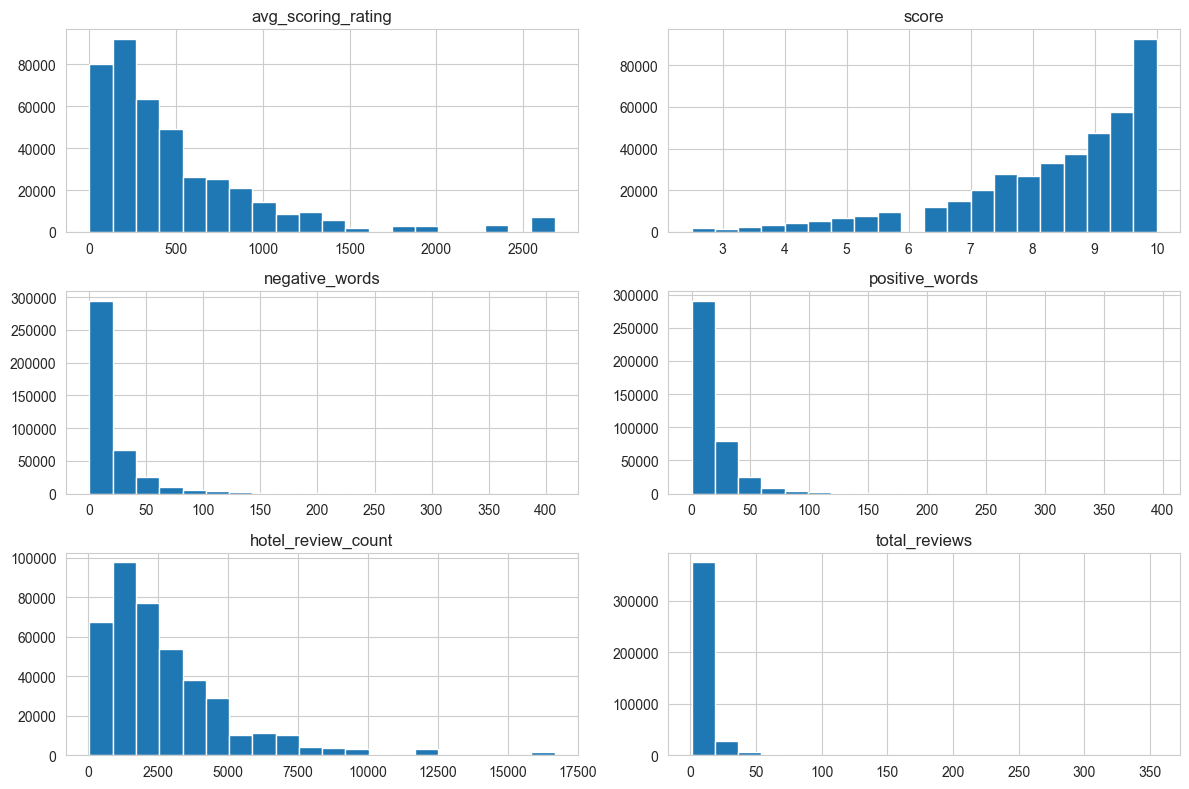

In [26]:
plt.figure(figsize=(12, 8))

# Выводим гистограмму по данным
for i, col in enumerate(num_cols):
    plt.subplot(3, 2, i + 1)
    plt.hist(df[col], bins=20)
    plt.title(col)

plt.tight_layout()
plt.show()

Мы видим, что у нас почти во всех столбцах есть выбросы около нуля, ничего экстраординарного. Интерес вызывает только столбец `score`, так как 'провал' в значении '6'. У нас проблема

#### Предобработка выбросов

Когда мы выводили гистограммы, мы увидели, что там присутствуют выбросы, посмотрим на них подробнее

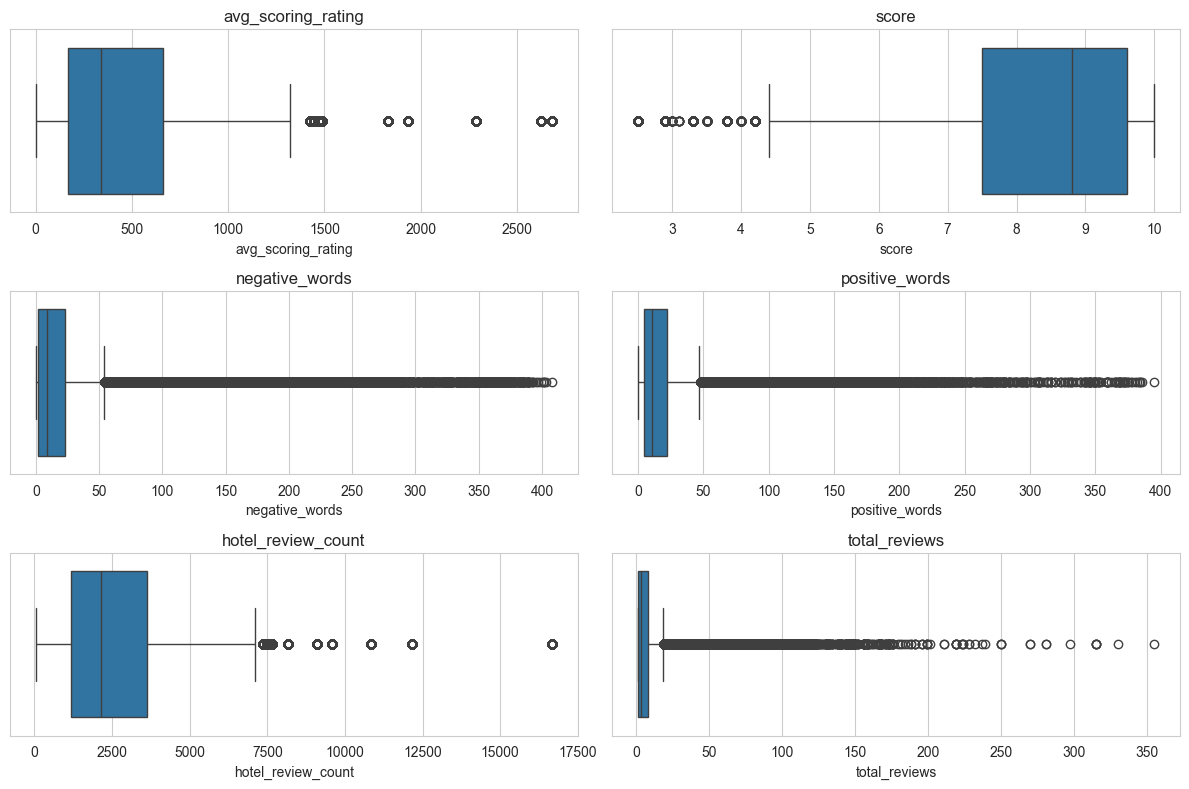

In [27]:
plt.figure(figsize=(12, 8))

# Выводим диаграммы размаха
for i, col in enumerate(num_cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=col, data=df)
    plt.title(col)

plt.tight_layout()
plt.show()

Мы так же видим, что у нас присутствуют выбросы, но они в пределах 'нормы'. Никаких сверхбольших значений не наблюдаем, скорее всего это просто единичные большие отели. Возможно, стоит удалить отели, у которых больше 8000 отзывов. Это единичные случаи, которые могут помешать модели уловить закономерность. Нужно посмотреть, какое количество записей с отелями, у которых много отзывов

In [28]:
print('Процент выбросов от общего числа данных',
      (df[df['hotel_review_count'] >= 8000]['hotel'].count() / df.shape[0]) * 100)

df[df['hotel_review_count'] >= 8000]['hotel'].count()

Процент выбросов от общего числа данных 3.499694349838442


np.int64(14427)

Выбросы составляют всего 3.5% от общего числа данных, однако это все равно достаточное большое количество данных (14 000) записей. Это позволит модели обучиться и уловить закономерности, потому оставим данные выбросы

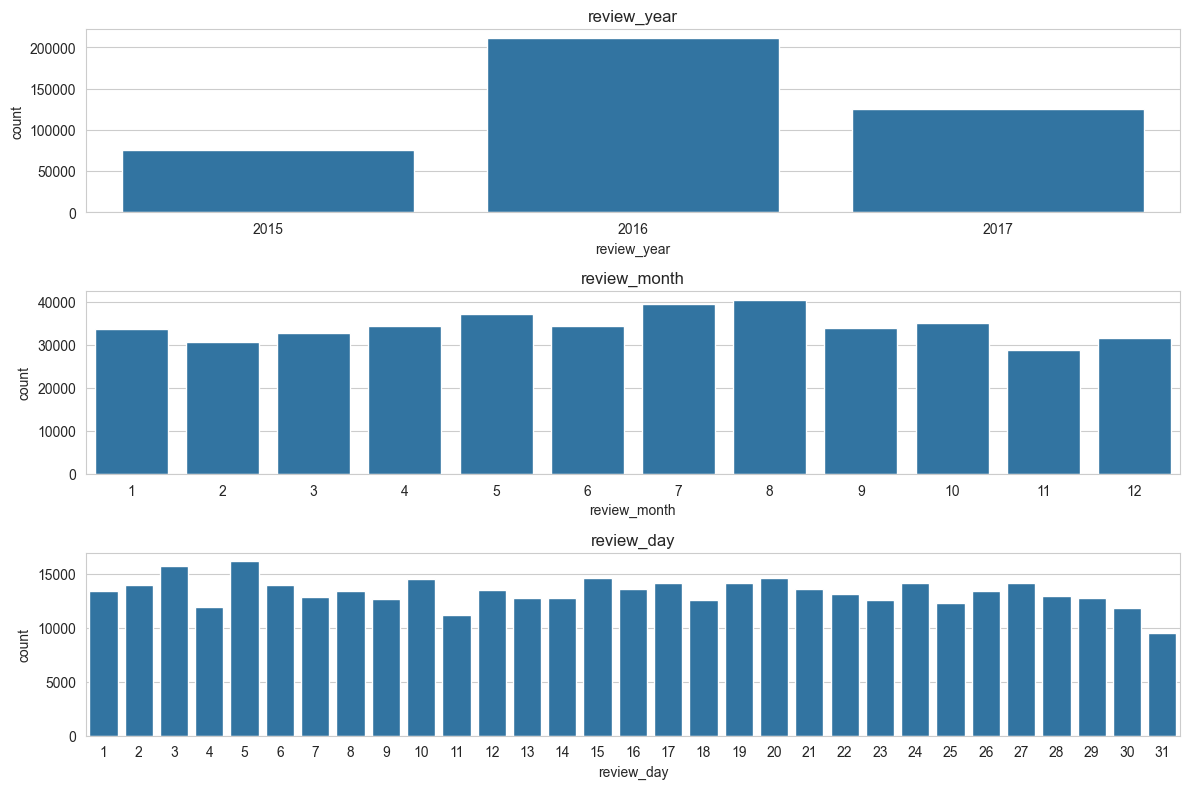

In [29]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(date_cols[1:]):
    plt.subplot(3, 1, i + 1)
    sns.countplot(x=col, data=df)
    plt.title(col)

plt.tight_layout()
plt.show()

Мы видим, что все данные у нас распределены почти равномерно. Можно только выделить, что в 2015-м году было очень мало отзывов в сравнении с 2016-м и 2017-м годами

### Предобработка категориальных столбцов.

У нас есть столбец с метками, которые были в заказе пользователя. Выделим все метки и проставим

In [30]:
# Функции для выделения тегов

def normalize_tags(tag_str, separator='|'):
    """
    Преобразует строковое представление списка тегов в одну строку с разделителем.

    Пример:
    Вход: '[\' Business trip \', \' Solo traveler \', ...]'
    Выход: 'Business trip|Solo traveler|...'
    """
    try:
        # Безопасно преобразуем строку в список
        raw_list = ast.literal_eval(tag_str)
        # Очищаем теги от лишних пробелов и объединяем в строку
        cleaned_tags = [tag.strip() for tag in raw_list]
        return separator.join(cleaned_tags)
    except (SyntaxError, ValueError) as e:
        print(f'Ошибка обработки строки: {e}')
        return ''  # Возвращаем пустую строку при ошибке


def parse_tag(tag):
    """
    Парсит отдельный тег и возвращает словарь с категориями.
    """
    tag = tag.strip()
    result = {}

    # Питомцы
    if tag == 'With a pet':
        return {'pets': 1}

    # Тип поездки
    if tag in ['Business trip', 'Leisure trip']:
        return {'trip_type': tag}

    # Тип путешественника
    traveler_types = [
        'Solo traveler', 'Couple', 'Group',
        'Family with young children', 'Family with older children',
        'Travelers with friends'
    ]
    if tag in traveler_types:
        return {'traveler_type': tag}

    # Длительность пребывания
    stay_match = re.match(r'Stayed (\d+) night[s]?', tag)
    if stay_match:
        return {'stay_duration_days': int(stay_match.group(1))}

    # Устройство отправки
    device_match = re.match(r'Submitted from a (mobile|desktop|tablet) device', tag)
    if device_match:
        return {'submission_device': device_match.group(1)}

    # Количество комнат
    room_count_match = re.match(r'(\d+) rooms?', tag)
    if room_count_match:
        return {'room_count': int(room_count_match.group(1))}

    # Тип номера
    if 'room' in tag.lower() or 'studio' in tag.lower() or 'suite' in tag.lower():
        return {'room_type': tag}

    # Неизвестный тег
    return {'unknown_tag': tag}


def parse_tags(df, column_name):
    """
    Обрабатывает теги в указанном столбце DataFrame и добавляет новые столбцы.

    Аргументы:
        df (pd.DataFrame): Исходный DataFrame.
        column_name (str): Имя столбца с тегами.

    Возвращает:
        pd.DataFrame: Обновленный DataFrame с новыми столбцами.
    """
    # Проверка наличия столбца
    if column_name not in df.columns:
        raise ValueError(f'Столбец {column_name} отсутствует в DataFrame.')

    # Копия DataFrame для избежания изменения оригинала
    df = df.copy()

    def process_row(row):
        line = row[column_name]

        # Разделение тегов
        if '|' in line:
            tags = [t.strip() for t in line.split('|')]
        else:
            try:
                tags = [t.strip() for t in eval(line)]
            except:
                tags = []

        # Инициализация результата
        result = defaultdict(lambda: None, {'pets': 0})

        for tag in tags:
            parsed = parse_tag(tag)
            for key, value in parsed.items():
                if key == 'pets':
                    result[key] = 1 if value == 1 else result[key]
                elif key == 'unknown_tag':
                    continue
                else:
                    result[key] = value

        return pd.Series(result)

    # Применение к каждой строке
    new_columns = df.apply(process_row, axis=1)

    # Объединение с оригинальным DataFrame
    df = pd.concat([df, new_columns], axis=1)

    return df

In [31]:
# Выделяем теги из тренировочного датасета
df['tags'] = df['tags'].apply(normalize_tags)
df = parse_tags(df, 'tags')

# Выделяем теги из тестового датасета
test_df['tags'] = test_df['tags'].apply(normalize_tags)
test_df = parse_tags(test_df, 'tags')

print('Train DataFrame columns:', df.columns, end='\n\n')
print('Test DataFrame columns:', test_df.columns)

Train DataFrame columns: Index(['address', 'avg_scoring_rating', 'review_date', 'hotel', 'nationality',
       'negative_review', 'negative_words', 'hotel_review_count',
       'positive_review', 'positive_words', 'total_reviews', 'score', 'tags',
       'days_since_review', 'latitude', 'longitude', 'review_year',
       'review_month', 'review_day', 'pets', 'room_count', 'room_type',
       'stay_duration_days', 'submission_device', 'traveler_type',
       'trip_type'],
      dtype='object')

Test DataFrame columns: Index(['address', 'avg_scoring_rating', 'review_date', 'hotel', 'nationality',
       'negative_review', 'negative_words', 'hotel_review_count',
       'positive_review', 'positive_words', 'total_reviews', 'tags',
       'days_since_review', 'latitude', 'longitude', 'review_year',
       'review_month', 'review_day', 'pets', 'room_count', 'room_type',
       'stay_duration_days', 'submission_device', 'traveler_type',
       'trip_type'],
      dtype='object')


In [32]:
# Смотрим, есть ли у нас различия в столбцах
print('Test - train:', set(test_df.columns) - set(df.columns))
print('Train - test:', set(df.columns) - set(test_df.columns))

Test - train: set()
Train - test: {'score'}


### Заполнение пропусков

Заполним пропуски в новых столбцах

In [33]:
# Выводим список пропусков в столбцах
pd.DataFrame({
    'train': df.isna().sum(),
    'test': test_df.isna().sum(),
})

,train,test
address,0,0.0
avg_scoring_rating,0,0.0
days_since_review,0,0.0
hotel,0,0.0
hotel_review_count,0,0.0
latitude,2600,668.0
longitude,2600,668.0
nationality,0,0.0
negative_review,0,0.0
negative_words,0,0.0


In [34]:
# Заполняем пропуски в тренировочном датасете
df['room_type'] = df['room_type'].fillna('unknown')
df['room_count'] = df['room_count'].fillna('unknown')
df['trip_type'] = df['trip_type'].fillna('unknown')
df['submission_device'] = df['submission_device'].fillna('desktop')

# Аналогичным образом заполняем пропуски в тестовом датасете
test_df['room_type'] = test_df['room_type'].fillna('unknown')
test_df['room_count'] = test_df['room_count'].fillna('unknown')
test_df['trip_type'] = test_df['trip_type'].fillna('unknown')
test_df['submission_device'] = test_df['submission_device'].fillna('desktop')

In [35]:
# Проверяем, корректно ли мы все заполнили
pd.DataFrame({
    'train': df.isna().sum(),
    'test': test_df.isna().sum(),
})

,train,test
address,0,0.0
avg_scoring_rating,0,0.0
days_since_review,0,0.0
hotel,0,0.0
hotel_review_count,0,0.0
latitude,2600,668.0
longitude,2600,668.0
nationality,0,0.0
negative_review,0,0.0
negative_words,0,0.0


## Feature engineering

Добавим новые признаки и преобразуем уже существующие

In [106]:
# Копируем датасеты
df_processed = df.copy()
test_df_processed = test_df.copy()

In [107]:
# Смотрим, больше у нас отрицательных или положительных слов
df_processed['neg_words_supremacy'] = df_processed.apply(
    lambda row: 1 if row['negative_words'] > row['positive_words'] else 0,
    axis=1)

test_df_processed['neg_words_supremacy'] = test_df_processed.apply(
    lambda row: 1 if row['negative_words'] > row['positive_words'] else 0,
    axis=1)

df_processed

,address,avg_scoring_rating,review_date,hotel,nationality,negative_review,negative_words,hotel_review_count,positive_review,positive_words,...,review_month,review_day,pets,room_count,room_type,stay_duration_days,submission_device,traveler_type,trip_type,neg_words_supremacy
0,Ndsm Plein 28 Amsterdam Noord 1033 WB Amsterda...,170,2017-04-17,DoubleTree by Hilton Hotel Amsterdam NDSM Wharf,United Kingdom,Too far from attractions Had to use ferry to ...,72,1593,Staff were very helpful Good breakfast,8,...,4,17,0.0,unknown,Queen Guest Room,3.0,mobile,Couple,Leisure trip,1
1,Ferdinand Bolstraat 194 Oud Zuid 1072 LW Amste...,114,2016-05-26,Savoy Hotel Amsterdam,Malaysia,Staff should handle customer document during ...,246,995,Very clean and cozy room Friendly and helpful...,41,...,5,26,0.0,unknown,Small Double Room,1.0,mobile,Couple,Leisure trip,1
2,18 Albert Embankment Lambeth London SE1 7TJ Un...,1195,2016-12-04,Park Plaza London Riverbank,United Kingdom,The hot breakfast could have been fresher tas...,19,4684,The room was to a high standard The staff wer...,19,...,12,4,0.0,unknown,Superior Double Room,2.0,mobile,Solo traveler,Business trip,0
3,Schottenring 24 01 Innere Stadt 1010 Vienna Au...,111,2017-04-30,Palais Hansen Kempinski Vienna,Oman,You have to pay the full amount before arrivi...,14,865,Everything was excellent,5,...,4,30,0.0,unknown,Deluxe Room,4.0,mobile,Couple,Leisure trip,1
4,Sabino de Arana 22 24 Les Corts 08028 Barcelon...,147,2017-01-22,Catalonia Rigoletto,United Kingdom,All Good,3,1562,The location was excellent for visiting the N...,11,...,1,22,0.0,unknown,Double or Twin Room,2.0,desktop,Family with young children,Leisure trip,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412585,7 Gracechurch Street City of London London EC3...,764,2017-03-31,Club Quarters Hotel Gracechurch,Belgium,Most of the coffee shops around the hotel are...,24,2996,Good location at walking distance to metro st...,75,...,3,31,0.0,unknown,Small Queen Room,1.0,desktop,Couple,Leisure trip,0
412586,Westminster Bridge Road Lambeth London SE1 7UT...,2623,2017-05-19,Park Plaza Westminster Bridge London,United Kingdom,Bar rather expensive,4,12158,Location and quality of the go Room was a gre...,17,...,5,19,0.0,unknown,Studio Triple,2.0,mobile,Family with young children,Leisure trip,0
412587,2 Stanhope Row Park Lane Westminster Borough L...,444,2015-12-07,Park Lane Mews Hotel,United Kingdom,Lack of ironing facilities Asked for iron to ...,21,2061,Excellent location comfortable and clean,6,...,12,7,0.0,unknown,Double Room,1.0,desktop,Solo traveler,Business trip,1
412588,No 1 Seething Lane City of London London EC3N ...,623,2017-04-16,Apex City Of London Hotel,United Kingdom,Having stayed at this hotel a number of times...,29,2750,All the staff where very friendly helpful Hot...,41,...,4,16,0.0,unknown,City King or Twin Room,1.0,mobile,Couple,Leisure trip,0


In [108]:
# Приводим тренировочный датасет к булевому типу
df_processed['negative_review'] = df_processed['negative_review'].apply(lambda x: 0 if x == 'No Negative' else 1)
df_processed['positive_review'] = df_processed['positive_review'].apply(lambda x: 0 if x == 'No Positive' else 1)

# Приводим тестовый датасет к булевому типу
test_df_processed['negative_review'] = test_df_processed['negative_review'].apply(
    lambda x: 0 if x == 'No Negative' else 1)
test_df_processed['positive_review'] = test_df_processed['positive_review'].apply(
    lambda x: 0 if x == 'No Positive' else 1)

In [109]:
df_processed

,address,avg_scoring_rating,review_date,hotel,nationality,negative_review,negative_words,hotel_review_count,positive_review,positive_words,...,review_month,review_day,pets,room_count,room_type,stay_duration_days,submission_device,traveler_type,trip_type,neg_words_supremacy
0,Ndsm Plein 28 Amsterdam Noord 1033 WB Amsterda...,170,2017-04-17,DoubleTree by Hilton Hotel Amsterdam NDSM Wharf,United Kingdom,1,72,1593,1,8,...,4,17,0.0,unknown,Queen Guest Room,3.0,mobile,Couple,Leisure trip,1
1,Ferdinand Bolstraat 194 Oud Zuid 1072 LW Amste...,114,2016-05-26,Savoy Hotel Amsterdam,Malaysia,1,246,995,1,41,...,5,26,0.0,unknown,Small Double Room,1.0,mobile,Couple,Leisure trip,1
2,18 Albert Embankment Lambeth London SE1 7TJ Un...,1195,2016-12-04,Park Plaza London Riverbank,United Kingdom,1,19,4684,1,19,...,12,4,0.0,unknown,Superior Double Room,2.0,mobile,Solo traveler,Business trip,0
3,Schottenring 24 01 Innere Stadt 1010 Vienna Au...,111,2017-04-30,Palais Hansen Kempinski Vienna,Oman,1,14,865,1,5,...,4,30,0.0,unknown,Deluxe Room,4.0,mobile,Couple,Leisure trip,1
4,Sabino de Arana 22 24 Les Corts 08028 Barcelon...,147,2017-01-22,Catalonia Rigoletto,United Kingdom,1,3,1562,1,11,...,1,22,0.0,unknown,Double or Twin Room,2.0,desktop,Family with young children,Leisure trip,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412585,7 Gracechurch Street City of London London EC3...,764,2017-03-31,Club Quarters Hotel Gracechurch,Belgium,1,24,2996,1,75,...,3,31,0.0,unknown,Small Queen Room,1.0,desktop,Couple,Leisure trip,0
412586,Westminster Bridge Road Lambeth London SE1 7UT...,2623,2017-05-19,Park Plaza Westminster Bridge London,United Kingdom,1,4,12158,1,17,...,5,19,0.0,unknown,Studio Triple,2.0,mobile,Family with young children,Leisure trip,0
412587,2 Stanhope Row Park Lane Westminster Borough L...,444,2015-12-07,Park Lane Mews Hotel,United Kingdom,1,21,2061,1,6,...,12,7,0.0,unknown,Double Room,1.0,desktop,Solo traveler,Business trip,1
412588,No 1 Seething Lane City of London London EC3N ...,623,2017-04-16,Apex City Of London Hotel,United Kingdom,1,29,2750,1,41,...,4,16,0.0,unknown,City King or Twin Room,1.0,mobile,Couple,Leisure trip,0


## Корреляционный анализ
Проведем корреляционный анализ столбцов с таргетом

In [110]:
df_processed = df_processed.drop(['review_date', 'tags', 'latitude', 'longitude', 'address'], axis=1)
test_df_processed = test_df_processed.drop(['review_date', 'tags', 'latitude', 'longitude', 'address'], axis=1)
df_processed

,avg_scoring_rating,hotel,nationality,negative_review,negative_words,hotel_review_count,positive_review,positive_words,total_reviews,score,...,review_month,review_day,pets,room_count,room_type,stay_duration_days,submission_device,traveler_type,trip_type,neg_words_supremacy
0,170,DoubleTree by Hilton Hotel Amsterdam NDSM Wharf,United Kingdom,1,72,1593,1,8,1,5.4,...,4,17,0.0,unknown,Queen Guest Room,3.0,mobile,Couple,Leisure trip,1
1,114,Savoy Hotel Amsterdam,Malaysia,1,246,995,1,41,1,9.6,...,5,26,0.0,unknown,Small Double Room,1.0,mobile,Couple,Leisure trip,1
2,1195,Park Plaza London Riverbank,United Kingdom,1,19,4684,1,19,3,8.8,...,12,4,0.0,unknown,Superior Double Room,2.0,mobile,Solo traveler,Business trip,0
3,111,Palais Hansen Kempinski Vienna,Oman,1,14,865,1,5,21,10.0,...,4,30,0.0,unknown,Deluxe Room,4.0,mobile,Couple,Leisure trip,1
4,147,Catalonia Rigoletto,United Kingdom,1,3,1562,1,11,1,9.2,...,1,22,0.0,unknown,Double or Twin Room,2.0,desktop,Family with young children,Leisure trip,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412585,764,Club Quarters Hotel Gracechurch,Belgium,1,24,2996,1,75,28,9.2,...,3,31,0.0,unknown,Small Queen Room,1.0,desktop,Couple,Leisure trip,0
412586,2623,Park Plaza Westminster Bridge London,United Kingdom,1,4,12158,1,17,4,10.0,...,5,19,0.0,unknown,Studio Triple,2.0,mobile,Family with young children,Leisure trip,0
412587,444,Park Lane Mews Hotel,United Kingdom,1,21,2061,1,6,1,7.9,...,12,7,0.0,unknown,Double Room,1.0,desktop,Solo traveler,Business trip,1
412588,623,Apex City Of London Hotel,United Kingdom,1,29,2750,1,41,4,8.3,...,4,16,0.0,unknown,City King or Twin Room,1.0,mobile,Couple,Leisure trip,0


/Users/moncervers/PycharmProjects/kaggle/hotel_review_score_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable hotel is large: 1492. Are you sure this is not an interval variable? Analysis for pairs of variables including hotel can be slow.
  warnings.warn(
/Users/moncervers/PycharmProjects/kaggle/hotel_review_score_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable room_type is large: 2181. Are you sure this is not an interval variable? Analysis for pairs of variables including room_type can be slow.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x11197b740>
Traceback (most recent call last):
  File "/Users/moncervers/.local/share/uv/python/cpython-3.12.10-macos-aarch64-none/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/moncervers/.local/share/uv/python/cpython-3.12.10-m

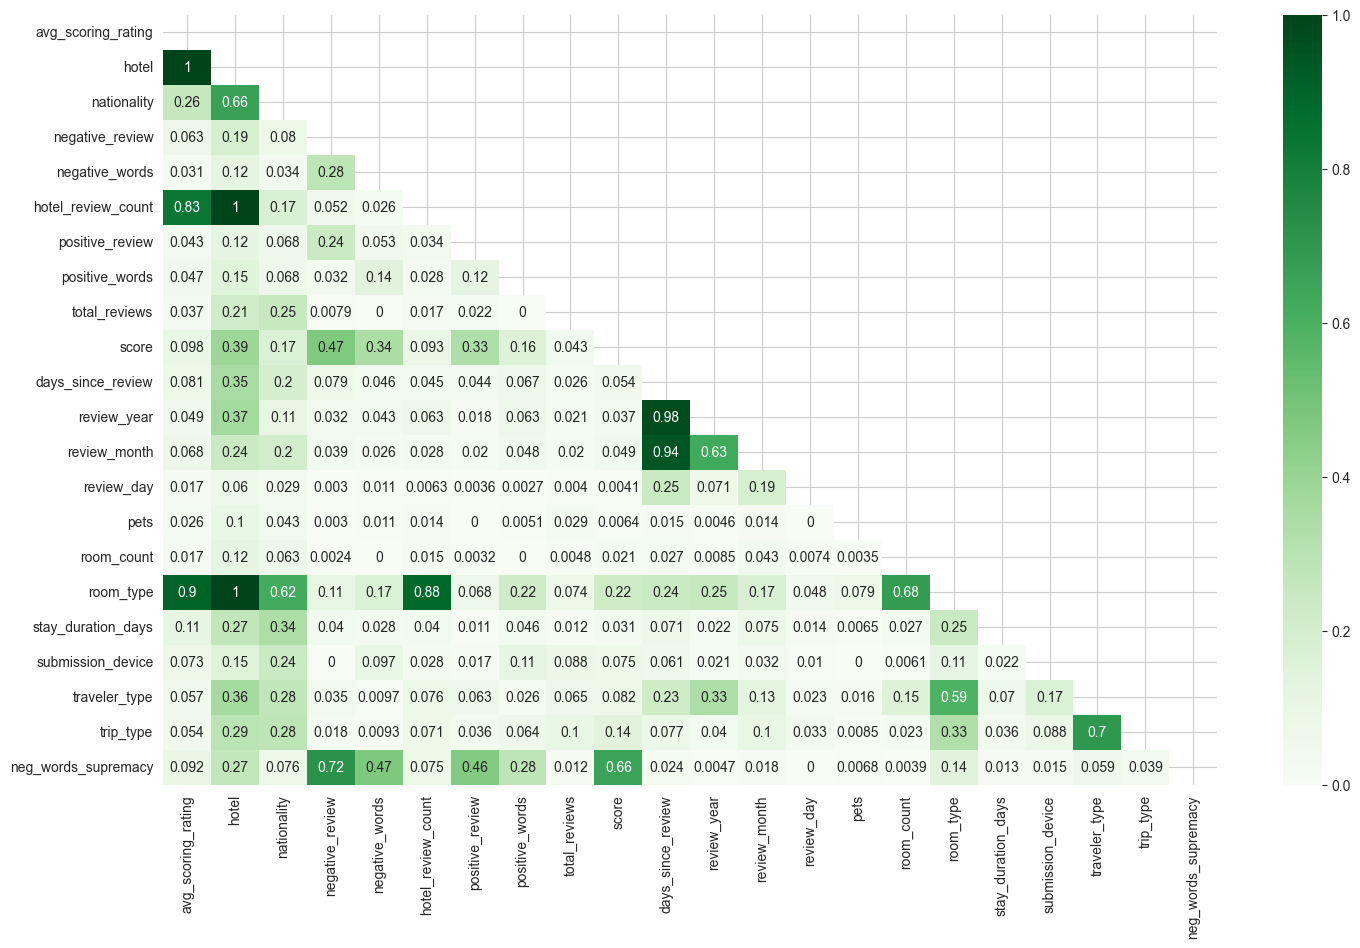

In [111]:
plt.figure(figsize=(17, 10))

# Определяем столбцы с числовыми значениями
ic = ['avg_scoring_rating', 'negative_words', 'hotel_review_count', 'positive_words', 'total_reviews',
      'days_since_review', 'review_year', 'review_month', 'review_day', 'pets', 'stay_duration_days', 'score']

# Рисуем матрицу корреляции
sns.heatmap(df_processed.phik_matrix(interval_cols=ic),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(df_processed.phik_matrix(interval_cols=ic),
                                      dtype=bool)))

plt.show()

In [112]:
# Удаляем столбцы с корреляцией ниже 0.1
df_processed = df_processed.drop(['avg_scoring_rating', 'hotel_review_count', 'total_reviews',
                                  'days_since_review', 'review_year', 'review_month', 'review_day',
                                  'pets', 'room_count', 'stay_duration_days', 'submission_device',
                                  'trip_type', 'traveler_type'],
                                 axis=1)

test_df_processed = test_df_processed.drop(['avg_scoring_rating', 'hotel_review_count', 'total_reviews',
                                            'days_since_review', 'review_year', 'review_month', 'review_day',
                                            'pets', 'room_count', 'stay_duration_days', 'submission_device',
                                            'trip_type', 'traveler_type'],
                                           axis=1)


/Users/moncervers/PycharmProjects/kaggle/hotel_review_score_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable hotel is large: 1492. Are you sure this is not an interval variable? Analysis for pairs of variables including hotel can be slow.
  warnings.warn(
/Users/moncervers/PycharmProjects/kaggle/hotel_review_score_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable room_type is large: 2181. Are you sure this is not an interval variable? Analysis for pairs of variables including room_type can be slow.
  warnings.warn(
/Users/moncervers/PycharmProjects/kaggle/hotel_review_score_prediction/.venv/lib/python3.12/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 3254052. Are interval variables set correctly?
  warnings.warn(
/Users/moncervers/PycharmProjects/kaggle/hotel_review_score_prediction/.venv/lib/python3.12/site-packages/phik/d

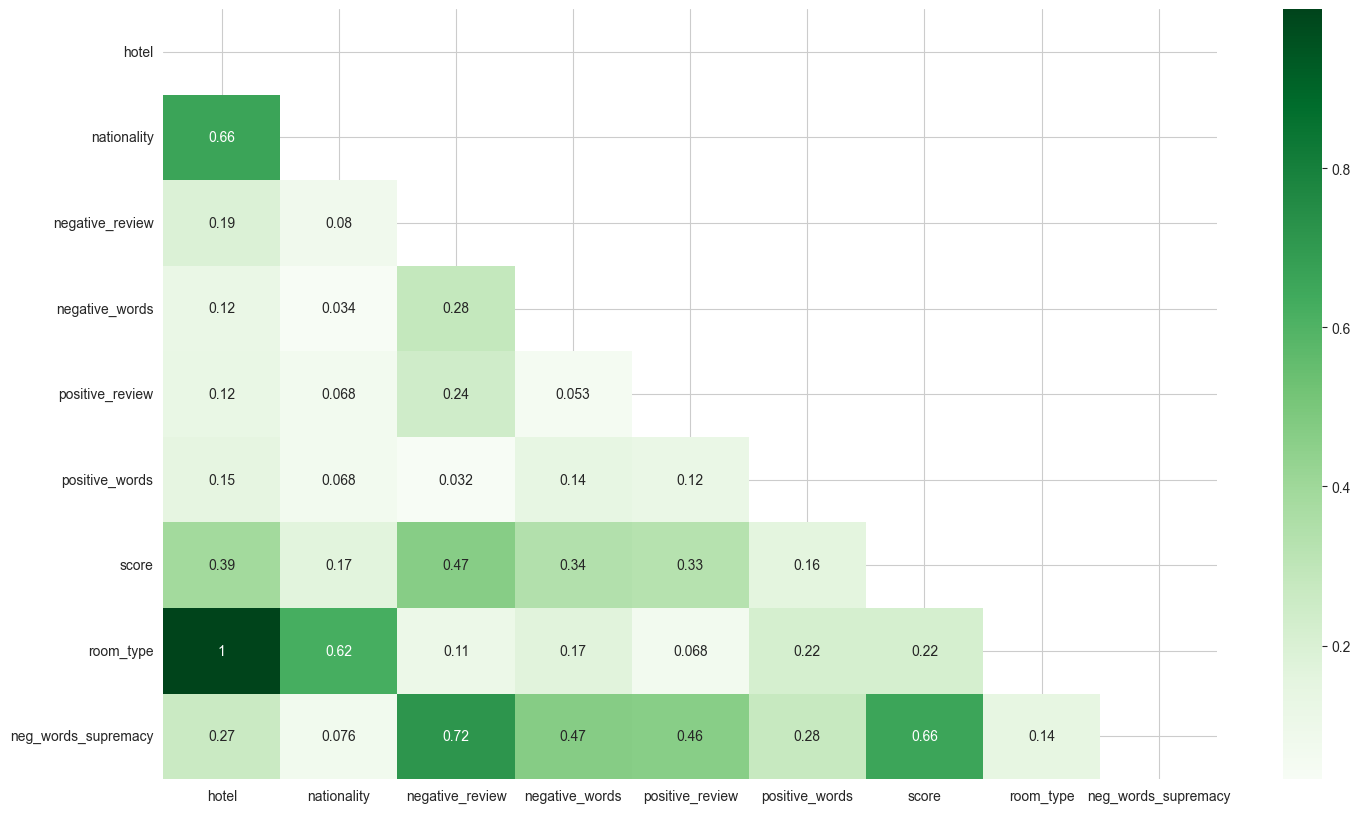

In [113]:
# Заново рисуем матрицу корреляции
plt.figure(figsize=(17, 10))

# Определяем столбцы с числовыми значениями
ic = ['negative_words', 'positive_words', 'score']

# Рисуем матрицу корреляции
sns.heatmap(df_processed.phik_matrix(interval_cols=ic),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(df_processed.phik_matrix(interval_cols=ic),
                                      dtype=bool)))

plt.show()

In [114]:
# Смотрим, есть ли у нас различия в столбцах
print('Test - train:', set(test_df.columns) - set(df.columns))
print('Train - test:', set(df.columns) - set(test_df.columns))

Test - train: set()
Train - test: {'score'}


## Создание пайплайна

Создадим пайплайн для обучения моделей

In [133]:
# Функция для метрики MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

mape_scorer = make_scorer(mape, greater_is_better=False)

In [117]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412236 entries, 0 to 412589
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   hotel                412236 non-null  object 
 1   nationality          412236 non-null  object 
 2   negative_review      412236 non-null  int64  
 3   negative_words       412236 non-null  int64  
 4   positive_review      412236 non-null  int64  
 5   positive_words       412236 non-null  int64  
 6   score                412236 non-null  float64
 7   room_type            412236 non-null  object 
 8   neg_words_supremacy  412236 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 31.5+ MB


In [118]:
# Преобразовываем столбцы в тренировочном датасете
df_processed['hotel'] = df_processed['hotel'].astype('category')
df_processed['nationality'] = df_processed['nationality'].astype('category')
df_processed['negative_review'] = df_processed['negative_review'].astype('category')
df_processed['positive_review'] = df_processed['positive_review'].astype('category')
df_processed['room_type'] = df_processed['room_type'].astype('category')
df_processed['neg_words_supremacy'] = df_processed['neg_words_supremacy'].astype('category')

# Преобразовываем столбцы в тестовом датасете
test_df_processed['hotel'] = test_df_processed['hotel'].astype('category')
test_df_processed['nationality'] = test_df_processed['nationality'].astype('category')
test_df_processed['negative_review'] = test_df_processed['negative_review'].astype('category')
test_df_processed['positive_review'] = test_df_processed['positive_review'].astype('category')
test_df_processed['room_type'] = test_df_processed['room_type'].astype('category')
test_df_processed['neg_words_supremacy'] = test_df_processed['neg_words_supremacy'].astype('category')

In [119]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412236 entries, 0 to 412589
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   hotel                412236 non-null  category
 1   nationality          412236 non-null  category
 2   negative_review      412236 non-null  category
 3   negative_words       412236 non-null  int64   
 4   positive_review      412236 non-null  category
 5   positive_words       412236 non-null  int64   
 6   score                412236 non-null  float64 
 7   room_type            412236 non-null  category
 8   neg_words_supremacy  412236 non-null  category
dtypes: category(6), float64(1), int64(2)
memory usage: 16.3 MB


In [ ]:
num_col_names = ['negative_words', 'positive_words']
cat_col_names = ['negative_review', 'positive_review', 'neg_words_supremacy']
label_col_names = []

In [ ]:
# # Определяем числовые и категориальные столбцы
# num_col_names = []
# cat_col_names = []
# label_col_names = []
#
# # Пайплайн для числовых значений
# num_pipeline = Pipeline([
#     (
#         'ImputerBeforeScaler',
#         SimpleImputer(strategy='most_frequent', missing_values=np.nan)
#     ),
#     (
#         'num',
#         StandardScaler()
#     )
# ])
#
# # Пайплайн для категориальных значений
# ohe_pipeline = Pipeline([
#     (
#         'OneHotEncoder',
#         OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
#     )
# ])
#
# # Собираем в один пайплайн по подготовке данных
# data_preprocessor = ColumnTransformer(
#     [
#         ('num', num_pipeline, num_col_names),
#         ('ohe', ohe_pipeline, cat_col_names),
#     ],
#     remainder='passthrough',
# )
#
# # Собираем все в конечный пайплайн
# final_pipeline = Pipeline(
#     [
#         ('preprocessor', data_preprocessor),
#         ('model', DummyClassifier(strategy='median')),
#     ]
# )

## Обучение LightGBM

In [135]:
# Создаем сетку гиперпараметров
lgbm_param_grid = {
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

In [139]:
lgbm_rs = RandomizedSearchCV(
    estimator=LGBMRegressor(
        objective='regression',
        metric='mape_scorer',
        boosting_type='gbdt',
        # categorical_feature=cat_columns,
        random_state=RANDOM_STATE,
    ),
    param_distributions=lgbm_param_grid,
    scoring='neg_mean_absolute_percentage_error',
    n_iter=5,
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

In [140]:
X_train = df_processed.drop('score', axis=1)
y_train = df_processed['score']

In [141]:
lgbm_rs.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3202
[LightGBM] [Info] Number of data points in the train set: 329788, number of used features: 8
[LightGBM] [Info] Start training from score 8.398262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(metric='mape_scorer',
                                           objective='regression',
                                           random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [-1, 5, 10],
                                        'min_child_samples': [20, 50, 100],
                                        'n_estimators': [100, 200],
                                        'num_leaves': [31, 63, 127],
                                        'subsample': [0.8, 1.0]},
                   random_state=42,
                   scoring='neg_mean_absolute_percentage_error')

In [142]:
lgbm_rs.best_score_

np.float64(-0.13386114038190314)

In [143]:
prediction = lgbm_rs.predict(test_df_processed)


array([9.44509786, 8.69214415, 8.51364019, ..., 9.02259067, 9.47835279,
       8.67844244], shape=(103148,))

In [150]:
submission = pd.DataFrame({
    'id':range(len(prediction)),
    'prediction': prediction,
})
submission

,id,prediction
0,0,9.445098
1,1,8.692144
2,2,8.513640
3,3,9.314419
4,4,7.970665
...,...,...
103143,103143,9.608675
103144,103144,8.804079
103145,103145,9.022591
103146,103146,9.478353


In [151]:
submission.to_csv('submission.csv', index = False)